# Testing Pepper VAE

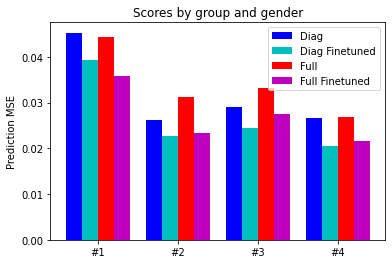

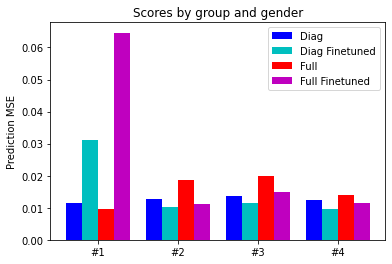

In [17]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array([
    [1.8111e-01, 2.4859e-01, 4.5384e-02, 6.7237e-02],
    [1.5732e-01, 2.1027e-01, 1.2481e-01, 2.1675e-01],
    [1.7696e-01, 2.4886e-01, 3.8383e-02, 5.9870e-02],
    [1.4314e-01, 1.9563e-01, 2.5841e-01, 6.5464e-01],
    [1.0470e-01, 1.3238e-01, 5.0419e-02, 7.1895e-02],
    [9.0591e-02, 1.1183e-01, 4.0474e-02, 5.4795e-02],
    [1.2509e-01, 1.6022e-01, 7.4698e-02, 1.0581e-01],
    [9.3374e-02, 1.1914e-01, 4.4369e-02, 5.4437e-02],
    [1.1582e-01, 1.3811e-01, 5.5158e-02, 7.5922e-02],
    [9.8171e-02, 1.1779e-01, 4.5455e-02, 6.0059e-02],
    [1.3258e-01, 1.6776e-01, 7.9680e-02, 1.2056e-01],
    [1.0983e-01, 1.3750e-01, 5.9901e-02, 9.3130e-02],
    [1.0625e-01, 1.6096e-01, 4.9654e-02, 6.8719e-02],
    [8.1720e-02, 1.3559e-01, 3.9035e-02, 4.6949e-02],
    [1.0734e-01, 1.6924e-01, 5.6105e-02, 8.5978e-02],
    [8.6682e-02, 1.5296e-01, 4.5382e-02, 5.4209e-02]
])/4
X = np.arange(4)
fig = plt.figure()
plt.bar(X + 0.0, data[0::4, 0], color = 'b', width = 0.2, label='Diag')
plt.bar(X + 0.2, data[1::4, 0], color = 'c', width = 0.2, label='Diag Finetuned')
plt.bar(X + 0.4, data[2::4, 0], color = 'r', width = 0.2, label='Full')
plt.bar(X + 0.6, data[3::4, 0], color = 'm', width = 0.2, label='Full Finetuned')
plt.ylabel('Prediction MSE')
plt.title('Scores by group and gender')
plt.xticks(X+0.3, ('#1', '#2', '#3', '#4'))
plt.legend()
plt.show()

X = np.arange(4)
fig = plt.figure()
plt.bar(X + 0.0, data[0::4, 2], color = 'b', width = 0.2, label='Diag')
plt.bar(X + 0.2, data[1::4, 2], color = 'c', width = 0.2, label='Diag Finetuned')
plt.bar(X + 0.4, data[2::4, 2], color = 'r', width = 0.2, label='Full')
plt.bar(X + 0.6, data[3::4, 2], color = 'm', width = 0.2, label='Full Finetuned')
plt.ylabel('Prediction MSE')
plt.title('Scores by group and gender')
plt.xticks(X+0.3, ('#1', '#2', '#3', '#4'))
plt.legend()
plt.show()